In [1]:
import numpy as np



import matplotlib.pylab as plt



In [2]:
from tqdm.notebook import trange


In [3]:
n = 100
p = n
d= 3

In [4]:
idx = np.round(np.linspace(0,n,num=(d+2))[1:(d+1)])

idx

X= np.zeros([n,n])
for i in range(n):
    for j in range(0,i):
        X[i,j] = np.abs(j-i)+1

X[:,0]=1

# X= np.random.normal(0,1,[n,n])


idx = np.round(np.linspace(0,n,num=(d+2))[1:(d+1)]).astype('int')

w0 = np.zeros([p])
w0[idx] = np.random.randn(d)+5
psi = X@w0


y = psi + np.random.randn(n) *1


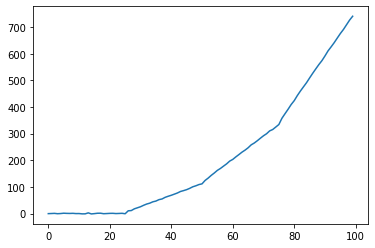

In [5]:
plt.plot(y)

In [6]:
X2 = X.T@X

In [7]:
Xy = X.T@y

In [8]:
Q,Lam,_ = np.linalg.svd(X2)

In [9]:
Lam = Lam[:(p-1)]
Q = Q[:,:(p-1)]

In [10]:
alpha = 10

In [11]:
theta = np.random.uniform(0,1,p) #np.linalg.solve(X2+np.eye(p),Xy) 

sigma2 = np.sum((y-X@theta)**2)/n

mu = np.random.uniform(0,1,1)
lam = np.random.uniform(0,1,p)*10

slab_indicator = (theta!=0)

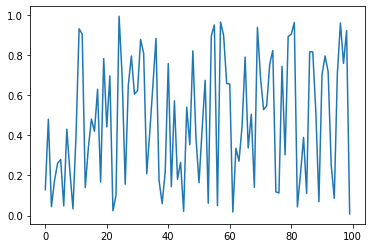

In [12]:
plt.plot(theta)

In [13]:
def Sample_a(theta,lam,sigma2,alpha ,slab_indicator):
    #inverse gaussain
    
    lam_tilde = 1./(1/lam+ 1/alpha)
    
    a = np.zeros(p)
    zero_idx = np.logical_not(slab_indicator)#np.abs(theta)==0
    non_zero_idx = slab_indicator #np.logical_not(zero_idx)

    if(np.sum(non_zero_idx)>0):
        ig_m = lam_tilde[non_zero_idx]* np.sqrt(sigma2)/ np.abs(theta[non_zero_idx])
        a[non_zero_idx] = 1/np.random.wald(ig_m, 1,np.sum(non_zero_idx) )

    a[zero_idx] = np.random.gamma(0.5,1/0.5, np.sum(zero_idx))
    return a

In [14]:
def inverse_gaussian_density(a, theta,lam,sigma , alpha):
    
    return  -np.log(2*np.pi)/2 - np.log(a)/2 - a* ( np.abs(theta)/a - lam*sigma)**2/2/(lam*sigma)**2

In [15]:
def a_density(a, theta,lam,sigma2, alpha):
    
    lam_tilde = 1./(1/lam+ 1/alpha)

    return  - np.log(a)/2 - theta**2/lam_tilde**2/2/sigma2/a - a/2

In [16]:
def SampleSlabIndicator(mu,lam,a,theta,sigma2,alpha,slab_indicator,eps=1E-3):


    p_slab = -mu/lam/np.sqrt(sigma2)
    p_spike = np.log(-np.expm1(p_slab))
    
    sigma = np.sqrt(sigma2)
    
    w1 = p_spike+ a_density(eps,theta,lam,sigma2,alpha) 
    w2 = p_slab + a_density(a,theta,lam,sigma2,alpha)

    slab = np.argmax(np.vstack([w1,w2]) + np.random.gumbel(0,1,[2,p]),0) ==1
    
    if (np.random.uniform(0,1,1)< slab.sum()/slab_indicator.sum()):
        s = slab
    else:
        s= slab_indicator

    return s

In [17]:
# def SampleSlabIndicator(mu,lam,a,theta,sigma2,alpha, slab_indicator):

#     lam_tilde = 1./(1/lam+ 1/alpha)

# #     c = np.sum(slab_indicator)
    
#     p_slab = -mu/lam_tilde/np.sqrt(sigma2)

#     p_spike = np.log(-np.expm1(p_slab)) #np.log(1- np.exp(p_slab ))

#     w1 = p_spike #+ inverse_gaussian_density(1E-5,theta,lam,np.sqrt(sigma2), alpha)
#     w2 = p_slab + inverse_gaussian_density(a,theta,lam_tilde,np.sqrt(sigma2), alpha)

#     slab_indicator = np.argmax(np.vstack([w1,w2]) + np.random.gumbel(0,1,[2,p]),0) ==1
    
#     return slab_indicator

In [18]:
def SampleTheta(lam, a, sigma2, slab_indicator,alpha):

    lam_tilde = 1./(1/lam+ 1/alpha)

    
    a_star = np.zeros(p)

    a_star[slab_indicator]= a[slab_indicator]

    a_starlam = np.diag(a_star*lam_tilde**2)

    theta = np.zeros(p)

    if(np.sum(slab_indicator)>0):
    
        a_starlam_sub_inv = np.diag(1/ (a_star[slab_indicator]*lam_tilde[slab_indicator]**2))
        A = (X2[slab_indicator][:,slab_indicator] + a_starlam_sub_inv)
        theta0 = np.random.randn(slab_indicator.sum())
        A_inv = np.linalg.inv(A)
        theta[slab_indicator] = np.linalg.cholesky(A_inv) @theta0 * np.sqrt(sigma2) + A_inv@Xy[slab_indicator]
        
    
    return theta

In [19]:
def ExpCDF(x,lam):
    return 1- np.exp(-x/lam)

def ExpInvCDF(y,lam):
    return  -np.log1p(-y)*lam

In [20]:
def GenLowTruncExpo(m,a):

    lb = ExpCDF(a,m)
  
    if lb< (1- 1E-2):
        x = ExpInvCDF ( (1- lb)* np.random.uniform(0,1,1)+lb, m )
    else:
        x = a
        
    return x
    

In [21]:
def SampleT(mu, lam, slab_indicator, theta,sigma2):

#     c = np.sum(slab_indicator)
    m = lam *np.sqrt(sigma2)
        
    t = ExpInvCDF(ExpCDF(mu, m) * np.random.uniform(0,1,p), m) - mu
    t[slab_indicator] = np.abs(theta)[slab_indicator]
    return t


def SampleMu(t,mu, lam,slab_indicator, sigma2):

#     c = np.sum(slab_indicator)
    zero_idx = np.logical_not(slab_indicator)
    
    beta = t+ mu
    
    if(zero_idx.sum()>0):
        max_beta = np.max(t[zero_idx]+ mu)
    else:
        max_beta = 1E-3

    m = 1/np.sum(1/lam[slab_indicator])*np.sqrt(sigma2)
    
#     if(np.min(t)<0):
#         lb = ExpCDF(-np.min(t),m)
#     else:
#         lb = 0
    
#     if lb< (1- 1E-2):
#         mu = ExpInvCDF ( (1- lb)* np.random.uniform(0,1,1)+lb, m )
#     else:
#         mu = -np.min(t)
    
    mu = GenLowTruncExpo(m, max_beta)
    
    t = beta - mu
    
    return [mu, t]

In [22]:
def SampleLam(t,slab_indicator,mu,sigma2):
    # lam prior: a,b
    a = 1
#     b = 1 
#     b = 1
    b= 0.01

#     c = np.sum(slab_indicator)

    beta = (t+mu)
    lam = 1/ np.random.gamma(a+1, 1/(beta/np.sqrt(sigma2)+ b ),p)
    
    ##adhoc:
#     lam[lam< .01] = 1E-5
    
    
    return lam

In [23]:
    ig_m = alpha* np.sqrt(sigma2)/ np.sum(np.abs(theta))
    a_r = 1/np.random.wald(ig_m,1,1)

In [24]:
def SampleSigma2(theta, t,mu,lam, alpha, slab_indicator):
    
    beta = t+mu
    
    ig_m = lam* np.sqrt(sigma2)/ beta
    a_beta = 1/np.random.wald(ig_m,1,p)
    
    ig_m = alpha* np.sqrt(sigma2)/ np.sum(np.abs(theta))
    a_r = 1/np.random.wald(ig_m,1,1)
    

    #approximation
    b1 = np.sum((y-X@theta)**2)/2 + np.sum(beta**2/lam**2/a_beta)/2  + (np.sum(np.abs(theta))**2/alpha**2/a_r)/2
    a1 = n/2  + p/2 + 1.0/2.0 + 0.5 #0.5 is the jefferey's prior sigma^-0.5

    return 1/np.random.gamma(a1, 1/b1,1)

In [52]:
trace_theta=[]

trace_slab=[]

In [26]:
sigma=1

In [27]:
mu0 = 10

In [53]:
for k in range(10000):

    a=  Sample_a(theta,lam,sigma2,alpha ,slab_indicator)
    
    slab_indicator= SampleSlabIndicator(mu,lam,a,theta,sigma2,alpha,slab_indicator,eps=1E-3)

    
    c = slab_indicator.sum(0)
    
    mu= mu0/c
    
    t = SampleT(mu, lam, slab_indicator, theta,sigma2)
#     mu, t = SampleMu(t,mu, lam,slab_indicator, sigma2)    

    
    theta = SampleTheta(lam, a, sigma2, slab_indicator,alpha)

    lam = SampleLam(t,slab_indicator,mu,sigma2)
    sigma2 = SampleSigma2(theta, t,mu,lam, alpha, slab_indicator)
    
    if k>5000:
        trace_theta.append(theta)
        trace_slab.append(slab_indicator)

    if k%1000==0:
        print(k)
        print(slab_indicator.sum())



0
3
1000
3
2000
3
3000
3
4000
3
5000
3
6000
3
7000
3
8000
3
9000
3


In [54]:
sigma2

array([0.70589186])

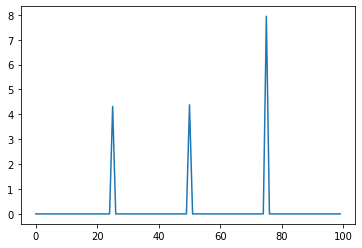

In [55]:
plt.plot(theta)

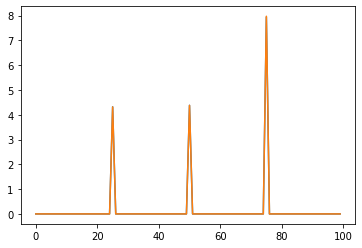

In [56]:
plt.plot(theta)
plt.plot(w0)

In [57]:
slab_indicator.sum()

3

In [58]:
theta_mat = np.vstack(trace_theta)
slab_mat = np.vstack(trace_slab)

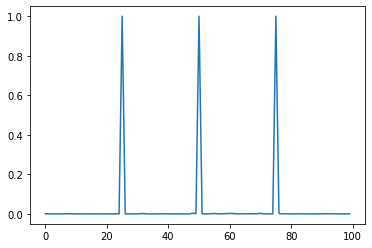

In [59]:
plt.plot(slab_mat.mean(0))

In [60]:
from statsmodels.tsa.stattools import acf

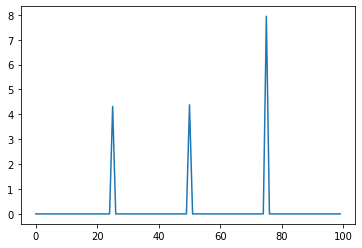

In [61]:
plt.plot(theta)

In [62]:
sigma2

array([0.70589186])

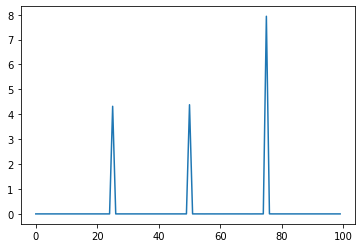

In [63]:
plt.plot(theta_mat.mean(0))

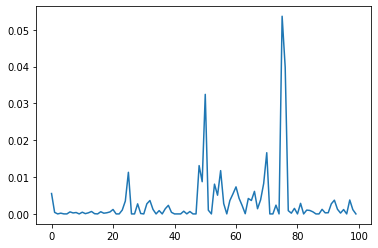

In [64]:
plt.plot(theta_mat.std(0))

In [65]:
theta_mat.mean(0)

array([ 3.03427730e-05, -1.22382246e-06,  0.00000000e+00,  1.81139178e-06,
        1.00145570e-07,  0.00000000e+00,  8.15453886e-06,  2.15521111e-06,
       -3.81318492e-06,  0.00000000e+00,  1.21754358e-05,  1.04031636e-06,
        1.10792881e-06,  8.94199473e-06,  8.55065742e-07,  0.00000000e+00,
        1.17835094e-05, -2.68934864e-06,  4.40185843e-06, -7.60326937e-06,
       -1.70332232e-05,  0.00000000e+00,  0.00000000e+00, -2.03485902e-05,
        7.46184355e-05,  4.32135723e+00,  0.00000000e+00,  0.00000000e+00,
       -8.73336606e-06,  1.53482554e-06,  0.00000000e+00, -6.42925154e-05,
        6.56782479e-05,  1.72585559e-05,  0.00000000e+00, -1.26625439e-05,
        0.00000000e+00,  2.89293625e-05,  3.27373817e-05,  9.84777284e-06,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.03941155e-05,
       -2.27958374e-07, -9.20638416e-06,  0.00000000e+00,  0.00000000e+00,
        4.66864907e-04,  1.52420805e-04,  4.38402364e+00, -1.63279999e-05,
        0.00000000e+00, -

In [66]:
# plt.plot((theta_mat!=0).sum(1))

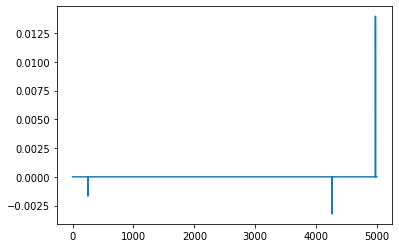

In [67]:
plt.plot((theta_mat[:,3]))

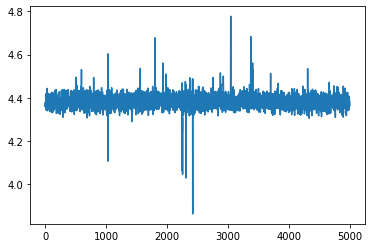

In [68]:
plt.plot((theta_mat[:,idx[1]]))

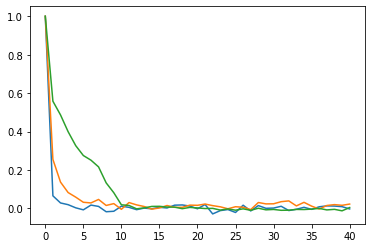

In [71]:
plt.plot(acf(theta_mat[:,idx[0]]))
plt.plot(acf(theta_mat[:,idx[1]]))
plt.plot(acf(theta_mat[:,idx[2]]))

In [72]:
sigma2

array([0.70589186])

In [ ]:
plt.plot(y)
plt.plot(X@theta)

In [ ]:
plt.plot(theta)

In [ ]:
plt.plot(lam)

In [ ]:
t.min()

In [ ]:
mu

In [ ]:
plt.plot(theta)

In [ ]:
plt.plot(theta)